# Notebook for running the snmachine pipeline on Supernova Photometric Classification Challenge simulated data

This notebook illustrates the use of the `snmachine` supernova classification package by classifying a subset simulated data from the supernova photometric classification challenge (SPCC). 

See Lochner et al. (2016) http://arxiv.org/abs/1603.00882

NOTE: The results here differ slightly from the paper because we're using a much smaller dataset (in the interest of disk space and speed) and the feature extraction methods use least squares here (which is must faster) whereas in the paper we used nested sampling for more accurate fits.

This image illustrates the how the pipeline works. As the user, you can choose what feature extraction method you want to use. Here we have three (four, technically, since there are two parametric models) but it's straighforward to write a new feature extraction method. Once features have been extracted, they can be run through one of several machine learning algorithms and again, it's easy to write your own algorithm into the pipeline. There's a convenience function in `snclassifier` to run a feature set through multiple algorithms and plot the result. The rest of this notebook goes through applying each of the feature extraction methods to a set of simulations and running all feature sets through different classification algorithms.

In [1]:
from snmachine import sndata, snfeatures, snclassifier, tsne_plot, example_data
import numpy as np
import matplotlib.pyplot as plt
import time, os, pywt,subprocess
from sklearn.decomposition import PCA
from astropy.table import Table,join,vstack
from astropy.io import fits
import sklearn.metrics 
import sncosmo
%matplotlib nbagg

/opt/anaconda3/envs/snmachine/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/anaconda3/envs/snmachine/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/opt/anaconda3/envs/snmachine/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
 

## Set up output structure

We make lots of output files so it makes sense to put them in one place. This is the recommended output file structure.

In [2]:
dataset='spcc'

In [3]:
# WARNING...
#Multinest uses a hardcoded character limit for the output file names. I believe it's a limit of 100 characters
#so avoid making this file path to lengthy if using nested sampling or multinest output file names will be truncated

#Change outdir to somewhere on your computer if you like
outdir=os.path.join('output_%s_no_z' %dataset,'')
out_features=os.path.join(outdir,'features') #Where we save the extracted features to
out_class=os.path.join(outdir,'classifications') #Where we save the classification probabilities and ROC curves
out_int=os.path.join(outdir,'int') #Any intermediate files (such as multinest chains or GP fits)

subprocess.call(['mkdir',outdir])
subprocess.call(['mkdir',out_features])
subprocess.call(['mkdir',out_class])
subprocess.call(['mkdir',out_int])

0

In [4]:
print(outdir)

output_spcc_no_z/


## Initialise dataset object

Load a subset of the SPCC DES simulated data (http://arxiv.org/abs/1008.1024)

In [5]:
#Data root
rt=os.path.join(example_data, 'SPCC_SUBSET','')

In [6]:
#We can automatically untar the data from here
# if not os.path.exists(rt):
#    subprocess.call(['tar', '-zxvf', 'SPCC_SUBSET.tar.gz'])

In [7]:
dat=sndata.Dataset(rt)

Reading data...
2000 objects read into memory.


In [8]:
#For now we restrict ourselves to three supernova types: Ia (1), II (2) and Ibc (3)
types=dat.get_types()
types['Type'][np.floor(types['Type']/10)==2]=2
types['Type'][np.floor(types['Type']/10)==3]=3

Now we can plot all the data and cycle through it (left and right arrows on your keyboard)

<IPython.core.display.Javascript object>


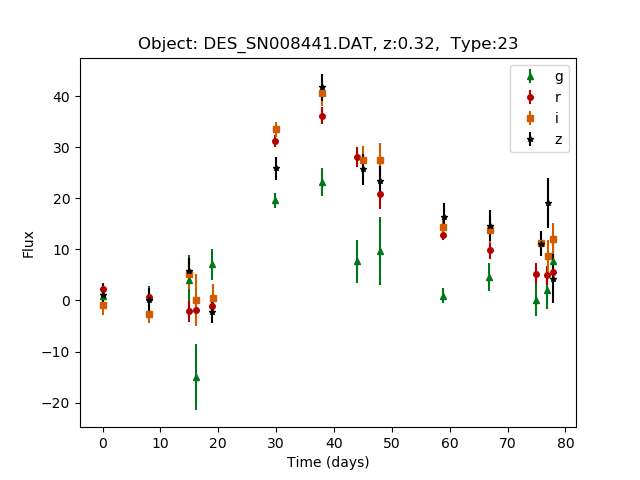

In [9]:
dat.plot_all()

Each light curve is represented in the Dataset object as an astropy table, compatible with `sncosmo`:

In [10]:
dat.data[dat.object_names[0]]

mjd,filter,flux,flux_error,zp,zpsys
float64,str4,float64,float64,float64,str2
0.0,desg,-0.7663,10.48,27.5,ab
0.01600000000325963,desr,3.049,7.841,27.5,ab
0.03200000000651926,desi,0.4541,9.312,27.5,ab
0.9770000000062282,desz,4.622,5.329,27.5,ab
1.985000000000582,desg,0.8938,3.205,27.5,ab
2.0,desr,3.493,2.427,27.5,ab
2.0160000000032596,desi,-2.318,4.311,27.5,ab
9.957000000002154,desz,39.55,27.34,27.5,ab
10.105999999999767,desg,-26.03,25.58,27.5,ab


## Extract features for the data

The next step is to extract useful features from the data. This can often take a long time, depending on the feature extraction method, so it's a good idea to save these to file (`snmachine` by default saves to astropy tables)

In [11]:
read_from_file=True #We can use this flag to quickly rerun from saved features
run_name=os.path.join(example_data, out_features,'%s_all' %dataset)

### 1. SALT2 Template features

In [12]:
#This is a Features object, not yet the extracted features
#We need to register the LSST bands with sncosmo (which is why lsst_bands=True)
salt2Feats=snfeatures.TemplateFeatures(sampler='leastsq') 

In [13]:
#This performs the actual feature extraction. All feature extraction methods are parallelised with multiprocessing, 
#just set nprocesses>1 for parallelisation.
if read_from_file:
    salt2_features=Table.read('%s_templates.dat' %run_name, format='ascii')
    blah=salt2_features['Object'].astype(str)
    salt2_features.replace_column('Object', blah)
else:
    salt2_features=salt2Feats.extract_features(dat,use_redshift=True,nprocesses=6,chain_directory=out_int)
    salt2_features.write('%s_templates.dat' %run_name, format='ascii')

In [14]:
#This code takes the fitted parameters and generates the model light curve for plotting purposes.
dat.set_model(salt2Feats.fit_sn,salt2_features)

Fitting supernova models...


KeyboardInterrupt: 

In [ ]:
#Now we can see how well the SALT2 model fits our light curves
dat.plot_all()

t-SNE plots: 
These are useful visualisation plots which embed high dimensional features into a lower dimensional space to indicate how well the features separate between classes (see https://lvdmaaten.github.io/tsne/)

In [ ]:
plt.figure()
tsne_plot.plot(salt2_features,join(salt2_features,types)['Type'])

### 2.1 Parametric fits - model 1 (Newling et al.)

In [15]:
mod1Feats=snfeatures.ParametricFeatures('newling',sampler='leastsq')

In [16]:
%%capture --no-stdout
if read_from_file:
    mod1_features=Table.read('%s_newling.dat' %run_name, format='ascii')
    blah=mod1_features['Object'].astype(str)
    mod1_features.replace_column('Object', blah)
else:
    mod1_features=mod1Feats.extract_features(dat,nprocesses=6,chain_directory=out_int)
    mod1_features.write('%s_newling.dat' %run_name, format='ascii')

In [17]:
#Unfortunately, sometimes the fitting methods return NaN for some parameters for these models.
for c in mod1_features.colnames[1:]:
    mod1_features[c][np.isnan(mod1_features[c])]=0

In [18]:
dat.set_model(mod1Feats.fit_sn,mod1_features)

Fitting supernova models...


KeyboardInterrupt: 

In [ ]:
dat.plot_all()

In [ ]:
plt.figure()
tsne_plot.plot(mod1_features,join(mod1_features,types)['Type'])

### 2.2 Parametric fits - model 2 (Karpenka et al.)

In [19]:
mod2Feats=snfeatures.ParametricFeatures('karpenka',sampler='leastsq')

In [20]:
%%capture --no-stdout
if read_from_file:
    mod2_features=Table.read('%s_karpenka.dat' %run_name, format='ascii')
    blah=mod2_features['Object'].astype(str)
    mod2_features.replace_column('Object', blah)
else:
    mod2_features=mod2Feats.extract_features(dat,nprocesses=4,chain_directory=out_int)
    mod2_features.write('%s_karpenka.dat' %run_name, format='ascii')

In [21]:
#Unfortunately, sometimes the fitting methods return NaN for some parameters for these models.
for c in mod2_features.colnames[1:]:
    mod2_features[c][np.isnan(mod2_features[c])]=0

In [22]:
dat.set_model(mod2Feats.fit_sn,mod2_features)

Fitting supernova models...


/Users/daniel/.local/lib/python3.6/site-packages/snmachine-1.1.1-py3.6.egg/snmachine/parametric_models.py:154: RuntimeWarning: overflow encountered in exp
  return A*(1+B*(t-t1)*(t-t1))*np.exp(-(t-t0)/T_fall)/(1+np.exp(-(t-t0)/T_rise))


KeyboardInterrupt: 

In [ ]:
dat.plot_all()

In [ ]:
plt.figure()
tsne_plot.plot(mod2_features,join(mod2_features,types)['Type'])

### 3. Wavelet features

The wavelet feature extraction process is quite complicated, although it is fairly fast. Remember to save the PCA eigenvalues, vectors and mean for later reconstruction!

In [23]:
waveFeats=snfeatures.WaveletFeatures()

In [24]:
%%capture --no-stdout
if read_from_file:
    wave_features=Table.read('%s_wavelets.dat' %run_name, format='ascii')
    #Crucial for this format of id's
    blah=wave_features['Object'].astype(str)
    wave_features.replace_column('Object', blah)
    PCA_vals=np.loadtxt('%s_wavelets_PCA_vals.dat' %run_name)
    PCA_vec=np.loadtxt('%s_wavelets_PCA_vec.dat' %run_name)
    PCA_mean=np.loadtxt('%s_wavelets_PCA_mean.dat' %run_name)
else:
    wave_features=waveFeats.extract_features(dat,nprocesses=6,output_root=out_int,save_output='all')
    wave_features.write('%s_wavelets.dat' %run_name, format='ascii')
    np.savetxt('%s_wavelets_PCA_vals.dat' %run_name,waveFeats.PCA_eigenvals)
    np.savetxt('%s_wavelets_PCA_vec.dat' %run_name,waveFeats.PCA_eigenvectors)
    np.savetxt('%s_wavelets_PCA_mean.dat' %run_name,waveFeats.PCA_mean)
    
    PCA_vals=waveFeats.PCA_eigenvals
    PCA_vec=waveFeats.PCA_eigenvectors
    PCA_mean=waveFeats.PCA_mean

In [ ]:
dat.set_model(waveFeats.fit_sn,wave_features,PCA_vec,PCA_mean,0,dat.get_max_length(),dat.filter_set)

In [ ]:
dat.plot_all()

In [ ]:
plt.figure()
tsne_plot.plot(wave_features,join(wave_features,types)['Type'])

## Classify

Finally, we're ready to run the machine learning algorithm. There's a utility function in the `snclassifier` library to make it easy to run all the algorithms available, including converting features to `numpy` arrays and rescaling them and automatically generating ROC curves and metrics. Hyperparameters are automatically selected using a grid search combined with cross-validation. All functionality can also be individually run from `snclassifier`.

Classifiers can be run in parallel, change this parameter to the number of processors on your machine (we're only running 4 algorithms so it won't help to set this any higher than 4).

In [25]:
nproc=4

In [26]:
#Available classifiers 
print(snclassifier.choice_of_classifiers)

['svm', 'knn', 'random_forest', 'decision_tree', 'boost_dt', 'boost_rf', 'nb', 'neural_network']


### 1. SALT2 Template features

<IPython.core.display.Javascript object>


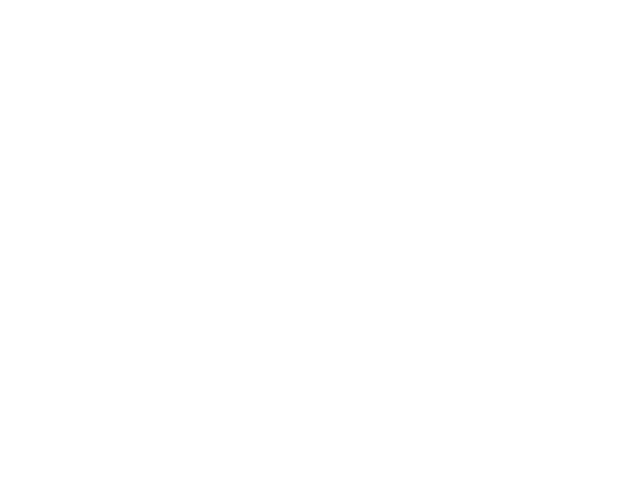

Created classifier of type:
Created classifier of type:
Created classifier of type:
Created classifier of type:
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')GaussianNB(priors=None)
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)






Optimised parameters: {}
Optimised parameters: {'n_neighbors': 21, 'weights': 'distance'}
Optimised parameters: {'C': 0.5623413251903491, 'gamma': 1.7782794100389228}
Optimised parameters: {'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
       

Classifier knn: AUC = 0.9100403958492889 FoM = 0.40689172865407847
Classifier svm: AUC = 0.9228123920649938 FoM = 0.42484090410357694
Classifier boost_dt: AUC = 0.9388205613371176 FoM = 0.4749536178107607

Time taken  1.2475240310033162 minutes


In [30]:
plt.figure()
clss=snclassifier.run_pipeline(salt2_features,types,output_name=os.path.join(out_class,'salt2'),
                          classifiers=['nb','knn','svm','boost_dt'], nprocesses=nproc, plot_roc_curve=False)


In [33]:
clss

In [37]:
?snclassifier.run_pipeline

### 2.1 Parametric fits - model 1 (Newling et al.)

In [ ]:
plt.figure()
clss=snclassifier.run_pipeline(mod1_features,types,output_name=os.path.join(out_class,'model1'),
                          classifiers=['nb','knn','svm','boost_dt'], nprocesses=nproc)

### 2.2 Parametric fits - model 2 (Karpenka et al.)

In [ ]:
plt.figure()
clss=snclassifier.run_pipeline(mod2_features,types,output_name=os.path.join(out_class,'model2'),
                          classifiers=['nb','knn','svm','boost_dt'], nprocesses=nproc)

### 3. Wavelet features

In [ ]:
plt.figure()
clss=snclassifier.run_pipeline(wave_features,types,output_name=os.path.join(out_class,'wavelets'),
                          classifiers=['nb','knn','svm','boost_dt'], nprocesses=nproc)